In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import optimize
from scipy.io import loadmat
import utils

%matplotlib inline

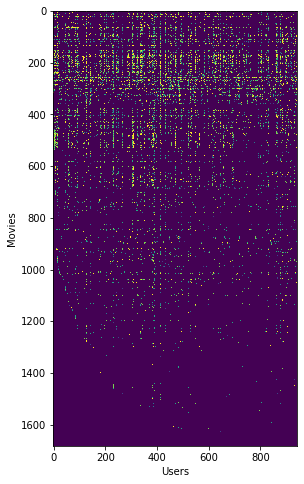

In [2]:
data = loadmat('ex8_movies.mat')
Y, R = data['Y'], data['R']

# Y is a 1682x943 matrix, containing ratings (1-5) of 
# 1682 movies on 943 users

# R is a 1682x943 matrix, where R(i,j) = 1 or 0 

plt.figure(figsize=(8, 8))
plt.imshow(Y)
plt.ylabel('Movies')
plt.xlabel('Users')
plt.grid(False)

In [3]:
def cofiCostFunc(params, Y, R, num_users, num_movies,
                      num_features, lambda_=0.0):
    
    X = params[:num_movies*num_features].reshape(num_movies, num_features)
    Theta = params[num_movies*num_features:].reshape(num_users, num_features)
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)
    
    J = (1 / 2) * np.sum(np.square((X.dot(Theta.T) - Y) * R)) + (lambda_ / 2) * np.sum(np.square(X)) + \
                                                                (lambda_ / 2) * np.sum(np.square(Theta))
    
    for i in range(R.shape[0]):
        
        idx = np.where(R[i, :] == 1)[0]
        Theta_temp = Theta[idx, :]
        Y_temp = Y[i, idx]
        X_grad[i, :] = np.dot(np.dot(X[i, :], Theta_temp.T) - Y_temp, Theta_temp) + lambda_ * X[i, :]
        
    for j in range(R.shape[1]):
        
        idx = np.where(R[:, j] == 1)[0]
        X_temp = X[idx, :]
        Y_temp = Y[idx, j]
        Theta_grad[j, :] = np.dot(np.dot(X_temp, Theta[j, :]) - Y_temp, X_temp) + lambda_ * Theta[j, :]
            
    grad = np.concatenate([X_grad.ravel(), Theta_grad.ravel()])
    return J, grad

In [4]:
#Pre-trained
data = loadmat('ex8_movieParams.mat')
X, Theta, num_users, num_movies, num_features = data['X'],\
        data['Theta'], data['num_users'], data['num_movies'], data['num_features']

num_users = 4
num_movies = 5
num_features = 3

X = X[:num_movies, :num_features]
Theta = Theta[:num_users, :num_features]
Y = Y[:num_movies, 0:num_users]
R = R[:num_movies, 0:num_users]

J, _ = cofiCostFunc(np.concatenate([X.ravel(), Theta.ravel()]),
                    Y, R, num_users, num_movies, num_features)
           
print('Cost at loaded parameters:  %.2f \n(this value should be about 22.22)' % J)

Cost at loaded parameters:  22.22 
(this value should be about 22.22)


In [5]:
def normalizeRatings(Y, R):
    m, n = Y.shape
    Ymean = np.zeros(m)
    Ynorm = np.zeros(Y.shape)

    for i in range(m):
        idx = R[i, :] == 1
        Ymean[i] = np.mean(Y[i, idx])
        Ynorm[i, idx] = Y[i, idx] - Ymean[i]

    return Ynorm, Ymean

In [6]:
def loadMovieList():
    with open('movie_ids.txt',  encoding='ISO-8859-1') as fid:
        movies = fid.readlines()

    movieNames = []
    for movie in movies:
        parts = movie.split()
        movieNames.append(' '.join(parts[1:]).strip())
    return movieNames

In [7]:
movieList = loadMovieList()
n_m = len(movieList)

my_ratings = np.zeros(n_m)

my_ratings[0] = 4
my_ratings[97] = 2
my_ratings[6] = 3
my_ratings[11]= 5
my_ratings[53] = 4
my_ratings[63] = 5
my_ratings[65] = 3
my_ratings[68] = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5

print('New user ratings:')
print('-----------------')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated %d stars: %s' % (my_ratings[i], movieList[i]))

New user ratings:
-----------------
Rated 4 stars: Toy Story (1995)
Rated 3 stars: Twelve Monkeys (1995)
Rated 5 stars: Usual Suspects, The (1995)
Rated 4 stars: Outbreak (1995)
Rated 5 stars: Shawshank Redemption, The (1994)
Rated 3 stars: While You Were Sleeping (1995)
Rated 5 stars: Forrest Gump (1994)
Rated 2 stars: Silence of the Lambs, The (1991)
Rated 4 stars: Alien (1979)
Rated 5 stars: Die Hard 2 (1990)
Rated 5 stars: Sphere (1998)


In [8]:
data = loadmat('ex8_movies.mat')
Y, R = data['Y'], data['R']

Y = np.hstack([my_ratings[:, None], Y])
R = np.hstack([(my_ratings > 0)[:, None], R])

Ynorm, Ymean = normalizeRatings(Y, R)

num_movies, num_users = Y.shape
num_features = 10

X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)

initial_parameters = np.concatenate([X.ravel(), Theta.ravel()])

options = {'maxiter': 100}

lambda_ = 10
res = optimize.minimize(lambda x: cofiCostFunc(x, Ynorm, R, num_users,
                                               num_movies, num_features, lambda_),
                        initial_parameters,
                        method='TNC',
                        jac=True,
                        options=options)
theta = res.x

X = theta[:num_movies*num_features].reshape(num_movies, num_features)
Theta = theta[num_movies*num_features:].reshape(num_users, num_features)

print('Recommender system learning completed.')

Recommender system learning completed.


In [9]:
p = np.dot(X, Theta.T)
my_predictions = p[:, 0] + Ymean

movieList = utils.loadMovieList()

ix = np.argsort(my_predictions)[::-1]

print('Top recommendations for you:')
print('----------------------------')
for i in range(10):
    j = ix[i]
    print('Predicting rating %.1f for movie %s' % (my_predictions[j], movieList[j]))

print('\nOriginal ratings provided:')
print('--------------------------')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated %d for %s' % (my_ratings[i], movieList[i]))

Top recommendations for you:
----------------------------
Predicting rating 5.0 for movie Someone Else's America (1995)
Predicting rating 5.0 for movie Aiqing wansui (1994)
Predicting rating 5.0 for movie Great Day in Harlem, A (1994)
Predicting rating 5.0 for movie Star Kid (1997)
Predicting rating 5.0 for movie Prefontaine (1997)
Predicting rating 5.0 for movie Entertaining Angels: The Dorothy Day Story (1996)
Predicting rating 5.0 for movie Marlene Dietrich: Shadow and Light (1996)
Predicting rating 5.0 for movie Saint of Fort Washington, The (1993)
Predicting rating 5.0 for movie They Made Me a Criminal (1939)
Predicting rating 5.0 for movie Santa with Muscles (1996)

Original ratings provided:
--------------------------
Rated 4 for Toy Story (1995)
Rated 3 for Twelve Monkeys (1995)
Rated 5 for Usual Suspects, The (1995)
Rated 4 for Outbreak (1995)
Rated 5 for Shawshank Redemption, The (1994)
Rated 3 for While You Were Sleeping (1995)
Rated 5 for Forrest Gump (1994)
Rated 2 for Sil